In [ ]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

100%|██████████| 9912422/9912422 [00:01<00:00, 6985492.81it/s] 


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 2127501.74it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 138592240.57it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18993548.12it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
X_train = MNIST_train.train_data
y_train= MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [ ]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [ ]:
X_train = X_train.float()
X_test = X_test.float()

In [ ]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [ ]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

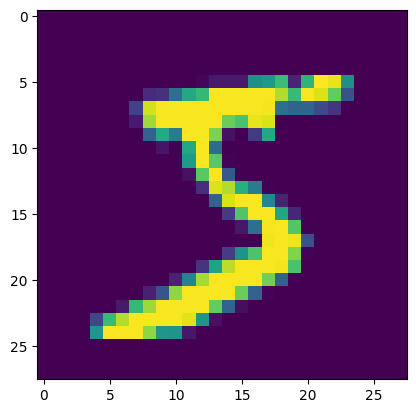

tensor(5)


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [ ]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [ ]:
class MNISTNet(torch.nn.Module):
  def __init__(self, n_hidden_neurons):
    super(MNISTNet, self).__init__()

    self.fc1 = torch.nn.Linear(28*28, n_hidden_neurons)
    self.act1 = torch.nn.Sigmoid()
    self.fc2 = torch.nn.Linear(n_hidden_neurons, 10)

  def forward(self, x):
    x = self.fc1(x)
    x = self.act1(x)
    x = self.fc2(x)
    return x

mnist_net = MNISTNet(100)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
!nvidia-smi

Tue Oct 17 05:15:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    30W /  70W |    875MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)
list(mnist_net.parameters())

[Parameter containing:
 tensor([[-0.0254,  0.0228,  0.0056,  ..., -0.0114, -0.0035,  0.0225],
         [ 0.0172, -0.0139,  0.0192,  ..., -0.0083,  0.0045, -0.0206],
         [-0.0070, -0.0057, -0.0128,  ...,  0.0213, -0.0036, -0.0149],
         ...,
         [-0.0313, -0.0216, -0.0193,  ...,  0.0117, -0.0023,  0.0258],
         [-0.0287,  0.0331,  0.0078,  ..., -0.0292,  0.0341,  0.0044],
         [-0.0283,  0.0104, -0.0145,  ..., -0.0129,  0.0160, -0.0128]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 1.7559e-02, -4.3088e-03,  5.8947e-04, -1.5237e-02, -5.7202e-03,
          2.0320e-02, -2.6771e-02,  1.5046e-03, -3.6740e-03,  2.7314e-02,
         -3.5267e-02,  1.6202e-03,  2.5047e-03,  2.3932e-02,  1.5547e-02,
          2.2168e-03,  1.7947e-02, -8.8012e-03,  9.5497e-03, -2.1096e-02,
          3.3168e-02, -3.3898e-02, -6.6754e-03,  1.5277e-02, -1.8927e-03,
         -1.6423e-02,  1.8165e-02, -8.7630e-04,  3.4078e-02, -7.3070e-03,
          1.0132e-02,  

In [ ]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [ ]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(10000):
  order = np.random.permutation(len(X_train))
  for start_index in range(0, len(X_train), batch_size):
    optimizer.zero_grad()

    batch_indexes = order[start_index:start_index+batch_size]

    x_batch = X_train[batch_indexes].to(device)
    y_batch = y_train[batch_indexes].to(device)

    preds = mnist_net.forward(x_batch)

    loss_val = loss(preds, y_batch)
    loss_val.backward()

    optimizer.step()

  test_preds = mnist_net.forward(X_test)
  test_loss_history.append(loss(test_preds, y_test).cpu().detach().numpy())

  accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
  test_accuracy_history.append(accuracy.cpu())
  print(accuracy)

tensor(0.9096, device='cuda:0')
tensor(0.9139, device='cuda:0')
tensor(0.9197, device='cuda:0')
tensor(0.9244, device='cuda:0')
tensor(0.9252, device='cuda:0')
tensor(0.9265, device='cuda:0')
tensor(0.9293, device='cuda:0')
tensor(0.9282, device='cuda:0')
tensor(0.9313, device='cuda:0')
tensor(0.9363, device='cuda:0')
tensor(0.9298, device='cuda:0')
tensor(0.9341, device='cuda:0')
tensor(0.9329, device='cuda:0')
tensor(0.9348, device='cuda:0')
tensor(0.9348, device='cuda:0')
tensor(0.9370, device='cuda:0')
tensor(0.9326, device='cuda:0')
tensor(0.9410, device='cuda:0')
tensor(0.9403, device='cuda:0')
tensor(0.9420, device='cuda:0')
tensor(0.9382, device='cuda:0')
tensor(0.9385, device='cuda:0')
tensor(0.9441, device='cuda:0')
tensor(0.9402, device='cuda:0')
tensor(0.9423, device='cuda:0')
tensor(0.9422, device='cuda:0')
tensor(0.9458, device='cuda:0')
tensor(0.9465, device='cuda:0')
tensor(0.9474, device='cuda:0')
tensor(0.9454, device='cuda:0')
tensor(0.9474, device='cuda:0')
tensor(0

KeyboardInterrupt: ignored

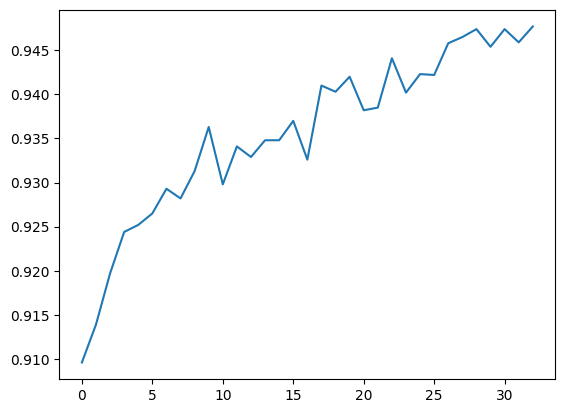

In [ ]:
plt.plot(test_accuracy_history)

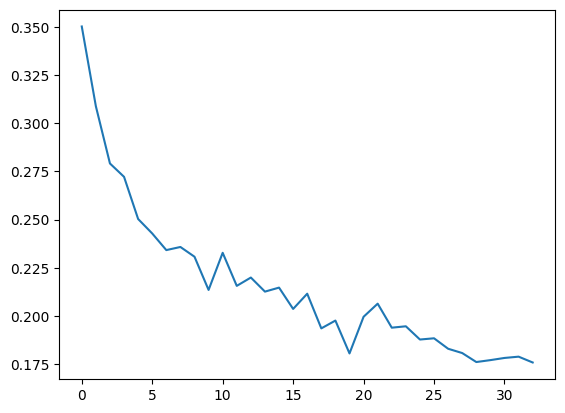

In [ ]:
plt.plot(test_loss_history)

In [ ]:
# 4.4
x = torch.tensor([[10., 20.]])

fc = torch.nn.Linear(2, 3)

w = torch.tensor([[11., 12.], [21., 22.], [31., 32]])
fc.weight.data = w

b = torch.tensor([[31., 32., 33.]])
fc.bias.data = b

fc_out = fc(x)
fc_out_alternative = torch.matmul(x, w.transpose(0, 1)) + b

print(fc_out == fc_out_alternative)

tensor([[True, True, True]])


In [ ]:
x = torch.tensor([[10., 20.]])

fc = torch.nn.Linear(2, 3)

w = torch.tensor([[11., 12.], [21., 22.], [31., 32]])
fc.weight.data = w

b = torch.tensor([[31., 32., 33.]])
fc.bias.data = b

fc_out = fc(x)
fc_out_summed = fc_out.sum()

fc_out_summed.backward()
weight_grad = fc.weight.grad
bias_grad = fc.bias.grad

w.requires_grad_(True)
b.requires_grad_(True)

our_formula = torch.matmul(x, w.transpose(0, 1)) + b
our_formula = our_formula.sum()
our_formula.backward()

print('fc_weight_grad:', weight_grad)
print('our_weight_grad:', w.grad)
print('fc_bias_grad:', bias_grad)
print('out_bias_grad:', b.grad)

fc_weight_grad: tensor([[10., 20.],
        [10., 20.],
        [10., 20.]])
our_weight_grad: tensor([[10., 20.],
        [10., 20.],
        [10., 20.]])
fc_bias_grad: tensor([[1., 1., 1.]])
out_bias_grad: tensor([[1., 1., 1.]])
